In [14]:
import sys
sys.path.append('..')
import json

from utils.preprocessing import PreprocessingPipeline
from utils.feature_extraction import compute_features
from feature_selection.fisher_score import fisher_score
from sklearn.feature_selection import SelectKBest

In [15]:
NTP_INTERVALS = {
    '1_marco': ('2024-05-28 15:21:46.830', '2024-05-28 15:36:21.000'),
    '2_svenja': ('2024-05-28 15:39:02.218', '2024-05-28 15:52:16.613'),
    '3_konstantin': ('2024-05-28 15:56:31.000', '2024-05-28 16:09:37.000'),
    '4_aleyna': ('2024-05-28 16:11:26.149', '2024-05-28 16:21:35.000'),
}

pipeline = PreprocessingPipeline(ntp_intervals=NTP_INTERVALS)
X, y = pipeline.get_full_data()
y = y.astype(str)
print(f'X shape: {X.shape}')
print(f'y shape: {y.shape}')

X shape: (6125, 100, 6)
y shape: (6125,)


In [16]:
# Extract features
X_features = compute_features(X)

100%|██████████| 6125/6125 [00:21<00:00, 287.13it/s]


## Fisher Score (Supervised feature selection algorithm)

In [53]:
n_features = 65

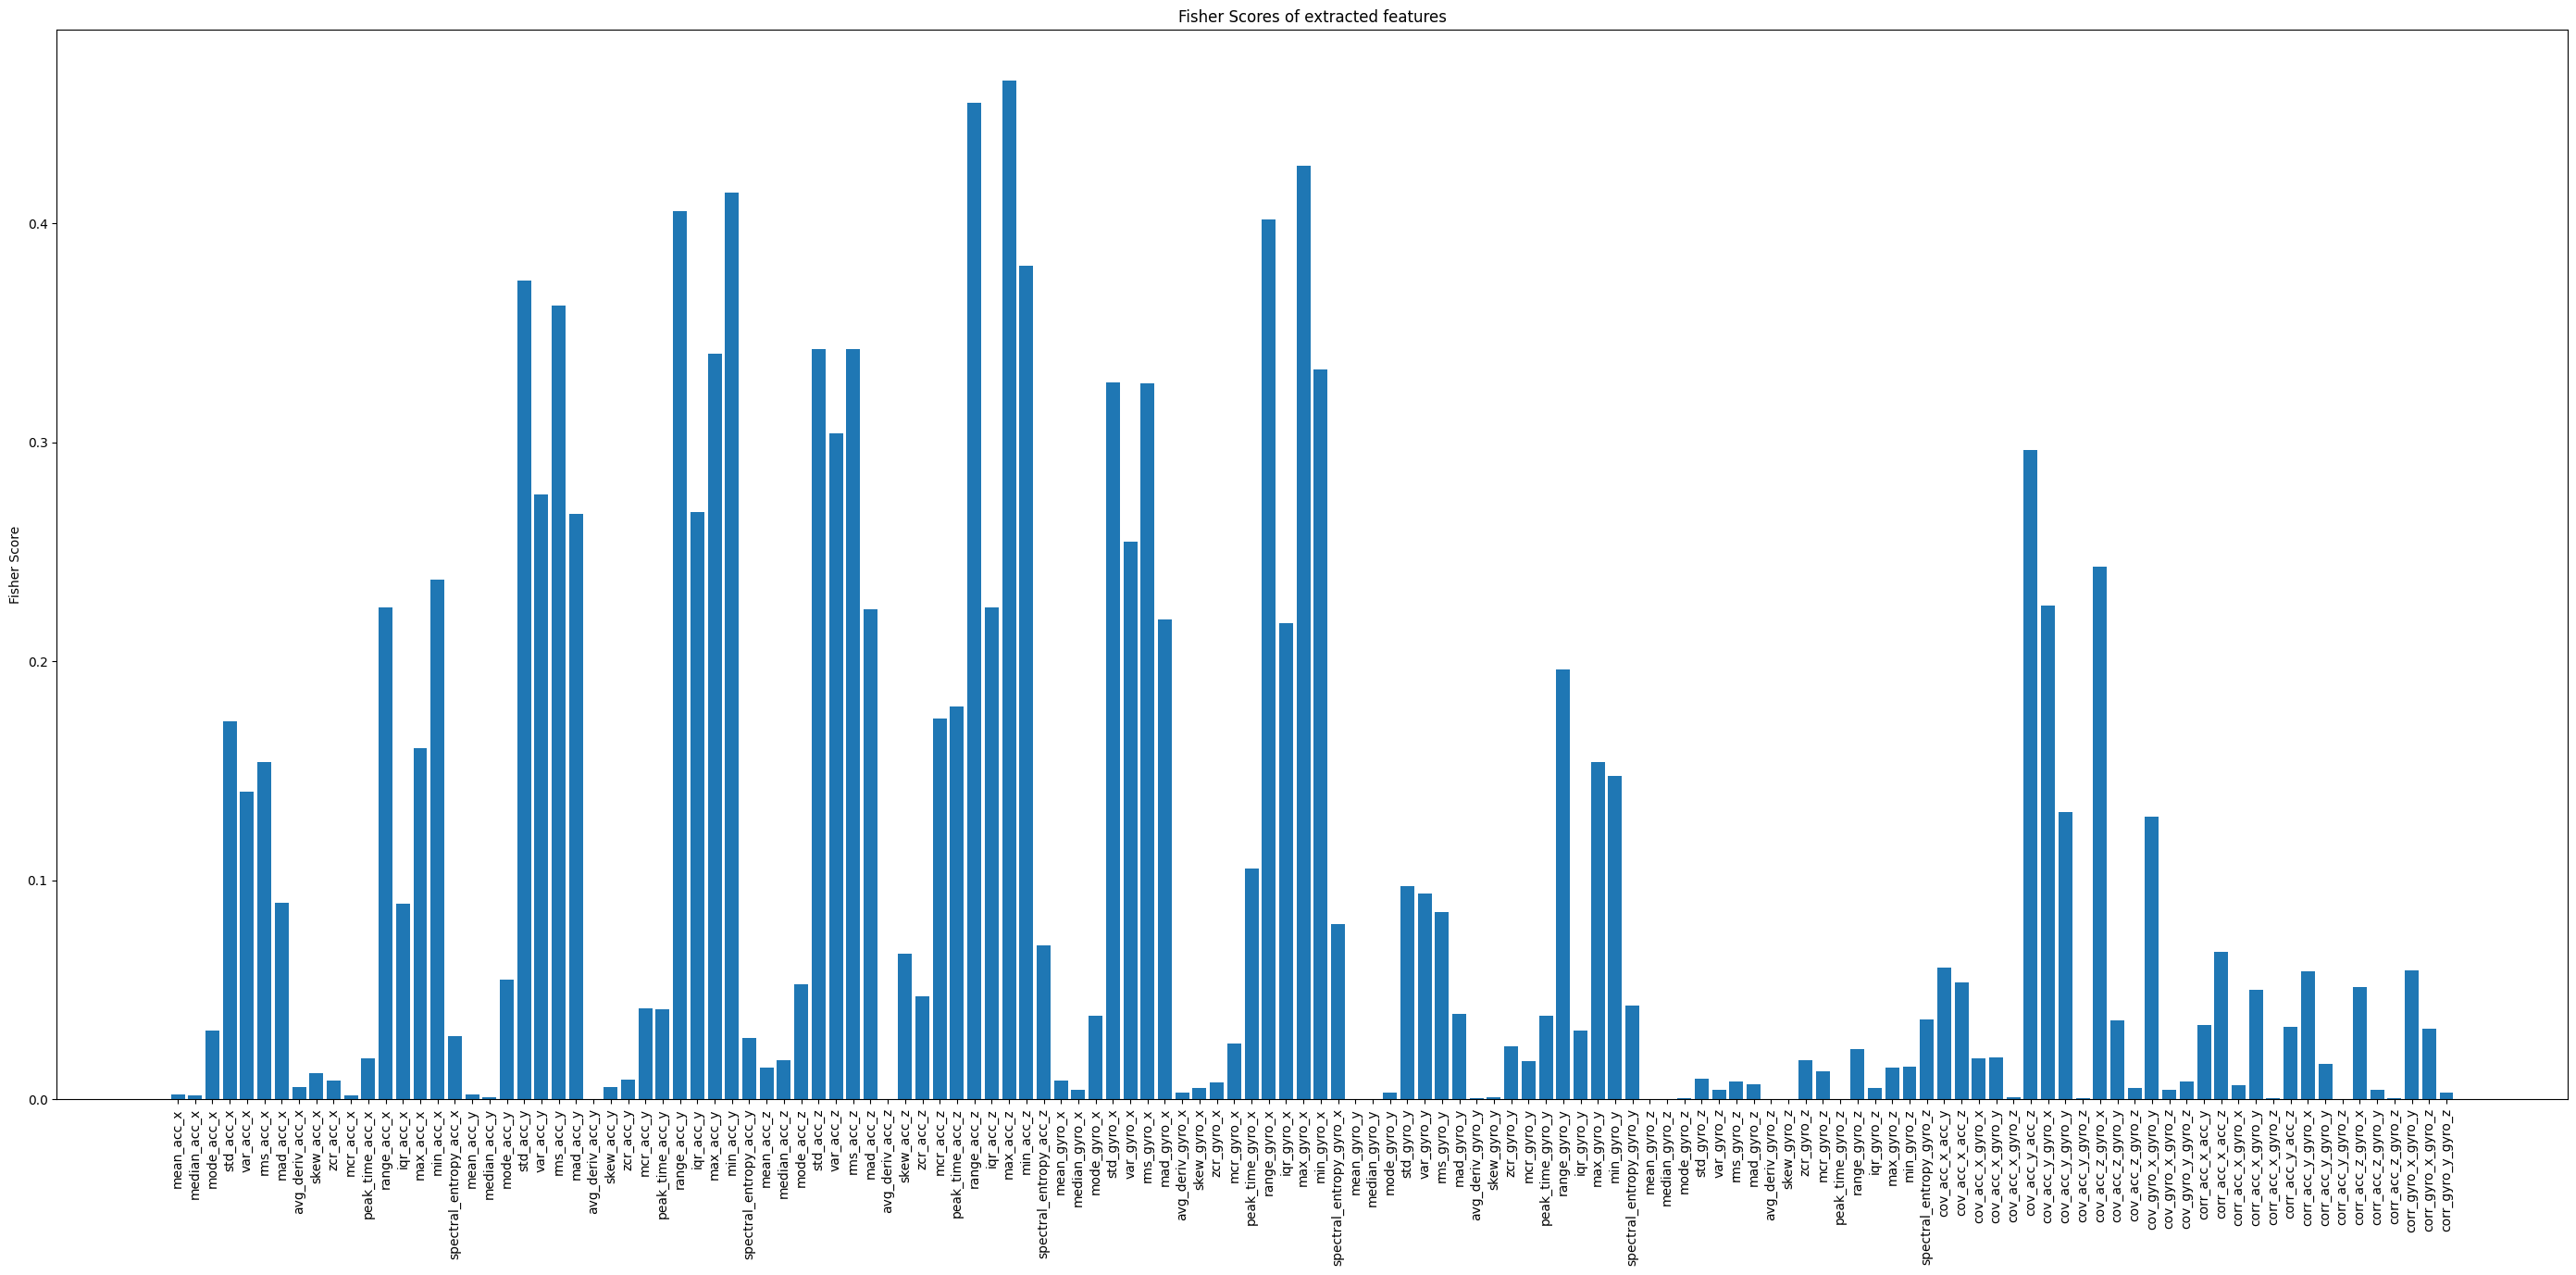

In [54]:
import matplotlib.pyplot as plt

fisher_scores = fisher_score(X_features, y)

# bar plot of fisher scores
plt.figure(figsize=(35, 15))
plt.title('Fisher Scores of extracted features')
plt.bar(X_features.columns, fisher_scores)
plt.ylabel('Fisher Score')
plt.xticks(rotation=90)
plt.show()

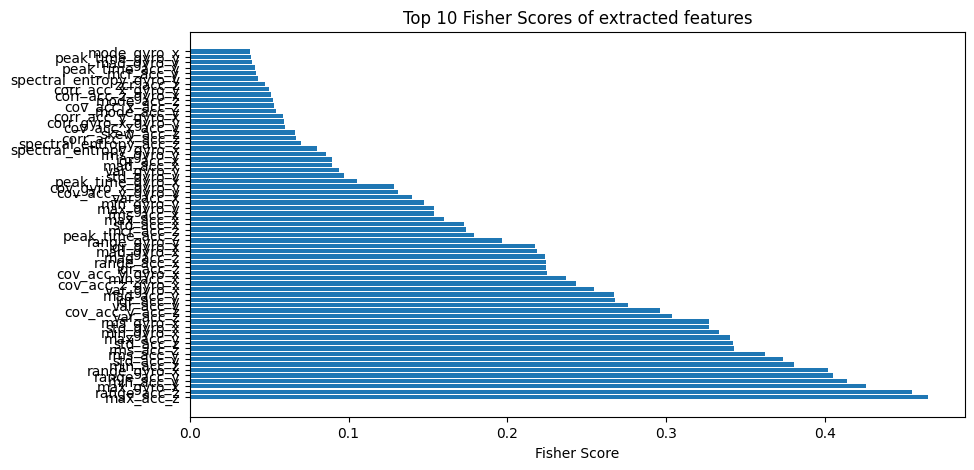

In [55]:
# Print top k features
top_k_features = fisher_scores.argsort()[::-1][:n_features]

# horizontal bar plot of best 10 features
plt.figure(figsize=(10,5 ))
plt.title('Top 10 Fisher Scores of extracted features')
plt.barh(X_features.columns[top_k_features], fisher_scores[top_k_features])
plt.xlabel('Fisher Score')

# plt.savefig('../results/fisher_scores.png')
plt.show()

## PCA (Unsupervised dimensionality reduction algorithm)

In [56]:
from sklearn.decomposition import PCA

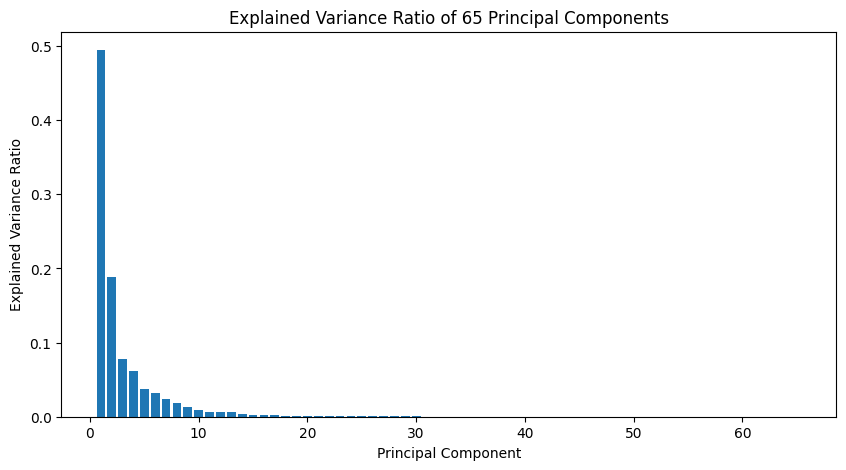

In [57]:
pca = PCA(n_components=n_features)
X_pca = pca.fit_transform(X_features)

# plot the explained variance ratio
plt.figure(figsize=(10, 5))
plt.bar(range(1, n_features+1), pca.explained_variance_ratio_)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title(f'Explained Variance Ratio of {n_features} Principal Components')
# plt.savefig('../results/explained_variance_ratio.png')
plt.show()

In [58]:
# compute reconstruction error
from sklearn.metrics import root_mean_squared_error

X_reconstructed = pca.inverse_transform(X_pca)
reconstruction_error = root_mean_squared_error(X_features, X_reconstructed)
print(f'Reconstruction error: {reconstruction_error}')

Reconstruction error: 0.04763240871676474


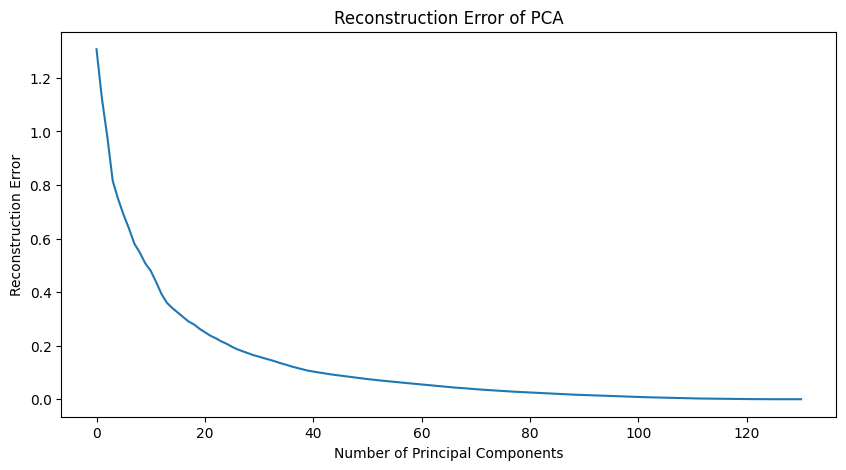

In [59]:
# elbow method to determine optimal number of components
reconstruction_errors = []

for i in range(1, len(X_features.columns)):
    pca = PCA(n_components=i)
    X_pca = pca.fit_transform(X_features)
    X_reconstructed = pca.inverse_transform(X_pca)
    reconstruction_error = root_mean_squared_error(X_features, X_reconstructed)
    reconstruction_errors.append(reconstruction_error)

plt.figure(figsize=(10, 5))
plt.plot(reconstruction_errors)
plt.xlabel('Number of Principal Components')
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction Error of PCA')
# plt.savefig('../results/pca_reconstruction_error.png')
plt.show()

## Recursive Feature Elimination with SVC

In [60]:
from sklearn.feature_selection import RFE
from sklearn.svm import SVC

svc = SVC(kernel="linear", C=1)
svm_selector = RFE(estimator=svc, n_features_to_select=n_features, step=1)
X_train_svm = svm_selector.fit_transform(X_features, y)

print(X_features.columns[svm_selector.support_])

Index(['mean_acc_x', 'median_acc_x', 'std_acc_x', 'var_acc_x', 'rms_acc_x',
       'mad_acc_x', 'avg_deriv_acc_x', 'peak_time_acc_x', 'iqr_acc_x',
       'mean_acc_y', 'median_acc_y', 'std_acc_y', 'var_acc_y', 'rms_acc_y',
       'mad_acc_y', 'peak_time_acc_y', 'iqr_acc_y', 'spectral_entropy_acc_y',
       'mean_acc_z', 'median_acc_z', 'std_acc_z', 'rms_acc_z', 'mad_acc_z',
       'avg_deriv_acc_z', 'peak_time_acc_z', 'iqr_acc_z',
       'spectral_entropy_acc_z', 'mean_gyro_x', 'std_gyro_x', 'rms_gyro_x',
       'mad_gyro_x', 'avg_deriv_gyro_x', 'iqr_gyro_x', 'min_gyro_x',
       'spectral_entropy_gyro_x', 'std_gyro_y', 'rms_gyro_y', 'mad_gyro_y',
       'avg_deriv_gyro_y', 'peak_time_gyro_y', 'iqr_gyro_y', 'cov_acc_x_acc_y',
       'cov_acc_x_acc_z', 'cov_acc_x_gyro_x', 'cov_acc_x_gyro_y',
       'cov_acc_x_gyro_z', 'cov_acc_y_gyro_x', 'cov_acc_y_gyro_y',
       'cov_acc_z_gyro_y', 'cov_acc_z_gyro_z', 'cov_gyro_x_gyro_y',
       'cov_gyro_y_gyro_z', 'corr_acc_x_acc_y', 'corr_acc_x_acc

## Sequential Feature Selection with KNN

In [61]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.neighbors import KNeighborsClassifier

In [62]:
sfs = SequentialFeatureSelector(estimator=KNeighborsClassifier(), n_features_to_select=n_features)
X_train_sfs = sfs.fit_transform(X_features, y)
X_features.columns[sfs.get_support()]

Index(['std_acc_x', 'var_acc_x', 'rms_acc_x', 'mad_acc_x', 'avg_deriv_acc_x',
       'peak_time_acc_x', 'mean_acc_y', 'median_acc_y', 'std_acc_y',
       'var_acc_y', 'rms_acc_y', 'mad_acc_y', 'avg_deriv_acc_y', 'iqr_acc_y',
       'spectral_entropy_acc_y', 'mean_acc_z', 'median_acc_z', 'std_acc_z',
       'rms_acc_z', 'mad_acc_z', 'avg_deriv_acc_z', 'zcr_acc_z', 'iqr_acc_z',
       'min_acc_z', 'mean_gyro_x', 'median_gyro_x', 'mode_gyro_x',
       'std_gyro_x', 'var_gyro_x', 'rms_gyro_x', 'mad_gyro_x',
       'avg_deriv_gyro_x', 'peak_time_gyro_x', 'rms_gyro_y',
       'avg_deriv_gyro_y', 'std_gyro_z', 'mad_gyro_z', 'avg_deriv_gyro_z',
       'cov_acc_x_acc_y', 'cov_acc_x_acc_z', 'cov_acc_x_gyro_x',
       'cov_acc_x_gyro_y', 'cov_acc_x_gyro_z', 'cov_acc_y_acc_z',
       'cov_acc_y_gyro_x', 'cov_acc_y_gyro_y', 'cov_acc_y_gyro_z',
       'cov_acc_z_gyro_x', 'cov_acc_z_gyro_y', 'cov_acc_z_gyro_z',
       'cov_gyro_x_gyro_y', 'cov_gyro_x_gyro_z', 'corr_acc_x_acc_y',
       'corr_acc_x_ac

In [63]:
# Save each set of selected features in json file
selected_features = {
    'fisher': list(X_features.columns[top_k_features]),
    'svc': list(X_features.columns[svm_selector.support_]),
    'knn': list(X_features.columns[sfs.get_support()]),
}

with open(f'../results/selected_features_{n_features}.json', 'w') as file:
    json.dump(selected_features, file, indent=4)

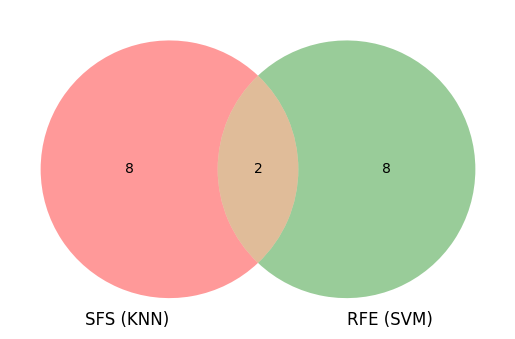

In [25]:
# Venn Diagram
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import json


knn_features = json.load(open('../results/selected_features_10.json'))['knn']
svm_features = json.load(open('../results/selected_features_10.json'))['svc']

# set1 = set(X_features.columns[top_k_features])
set2 = set(knn_features)
set3 = set(svm_features)

venn2([set2, set3], ('SFS (KNN)', 'RFE (SVM)'))
plt.show()

In [26]:
import pandas as pd

# Create df with selected features of knn and svm
data = {
    'SFS (KNN)': knn_features,
    'RFE (SVM)': svm_features
}

df = pd.DataFrame(data)
df


,SFS (KNN),RFE (SVM)
0,mean_acc_y,std_acc_y
1,std_acc_y,rms_acc_y
2,iqr_acc_y,mad_acc_y
3,avg_deriv_acc_z,rms_acc_z
4,zcr_acc_z,peak_time_acc_z
5,mean_gyro_x,std_gyro_x
6,mad_gyro_x,mad_gyro_x
7,cov_acc_y_acc_z,cov_acc_y_gyro_x
8,corr_acc_y_acc_z,cov_acc_z_gyro_z
9,corr_acc_z_gyro_z,corr_acc_y_gyro_x
